# Predicting Disk Failure

This is my showcase for @WalmartLabs System Engineering Intern Summer 2018
## Dataset

The dataset I chose is the Disk Failure (Data Source: https://www.backblaze.com/hard-drive-test-data.html)

## Description of Variables

The dataset contains 8202 observations of 10 variables:
* `SMART_1_Raw`: Read Error Rate -> Stores data related to the rate of hardware read errors that occurred when reading data from a disk surface.
* `SMART_2_Raw`: Reallocated Sectors Count —> Typically, raw value normally represents a count of the bad sectors that have been found and remapped. Thus, the higher the attribute value, the more sectors the drive has had to reallocate.
* `SMART_3_Raw`: Power-On Hours —> Raw value of this means total count of hours the drive is on power-on state.
* `SMART_4_Raw`: Temperature Celsius —> Current internal temperature.
* `SMART_5_Raw`: Current Pending Sector Count —> Shows the count of "unstable" sectors.

* `DiskFailure`: ‘Yes’ means failure, ‘No’ means condition of the hard drive is fine.
* `Date`: Refers to snapshot of hard drive in that particular day.
* `Model`: Manufacturer-assigned model number of the hard drive.
* `SerialNumber`: Manufacturer-assigned serial number of the hard drive.
* `CapacityBytes`: Refers to hard drive capacity in bytes.

## Problem Statement

I want to predict whether the hard drive is going to fail or not based on various indicators of drive reliability. I also want to detect categorical outliers in the data.

## Import modules

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## Data Pre-Processing

First, let's load the dataset and do some "touch"

In [158]:
# load dataset
df = pd.read_csv("data/disk_failures.csv")
df.describe()

,CapacityBytes,SMART_1_Raw,SMART_2_Raw,SMART_3_Raw,SMART_4_Raw,SMART_5_Raw
count,8.202000e+03,8.193000e+03,8194.000000,8194.000000,8194.000000,8194.000000
mean,-9.495720e+14,8.886273e+08,1627.711130,16702.866244,25.993654,212.670735
std,1.011448e+17,7.324664e+10,7805.379814,12182.257648,4.291065,3040.166391
min,-9.120000e+18,0.000000e+00,0.000000,6.000000,10.000000,0.000000
25%,2.000000e+12,0.000000e+00,0.000000,6874.250000,23.000000,0.000000
50%,3.000000e+12,4.297987e+07,0.000000,15349.500000,26.000000,0.000000
75%,4.000000e+12,1.444650e+08,0.000000,22414.750000,29.000000,0.000000
max,6.000000e+17,6.630000e+12,65224.000000,141415.000000,46.000000,65534.000000


In [159]:
from sklearn.preprocessing import Imputer
# Impute the null value by mean of the column
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
#df[['SMART_1_Raw']] = imp.fit_transform(df[['SMART_1_Raw']])
df[['SMART_1_Raw','SMART_2_Raw', 'SMART_3_Raw', 'SMART_4_Raw', 'SMART_5_Raw']] = \
    imp.fit_transform(df[['SMART_1_Raw','SMART_2_Raw', 'SMART_3_Raw', 'SMART_4_Raw', 'SMART_5_Raw']])
df[['SMART_1_Raw','SMART_2_Raw', 'SMART_3_Raw', 'SMART_4_Raw', 'SMART_5_Raw']].isnull().sum()

SMART_1_Raw    0
SMART_2_Raw    0
SMART_3_Raw    0
SMART_4_Raw    0
SMART_5_Raw    0
dtype: int64

Scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size

In [160]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df[['SMART_1_Raw', \
    'SMART_2_Raw', \
    'SMART_3_Raw', \
    'SMART_4_Raw', \
    'SMART_5_Raw']] \
    = min_max_scaler.fit_transform(df[['SMART_1_Raw', \
                                       'SMART_2_Raw', \
                                       'SMART_3_Raw', \
                                       'SMART_4_Raw', \
                                       'SMART_5_Raw']])

## Data Exploration

In [161]:
df.groupby('DiskFailure').mean()

,CapacityBytes,SMART_1_Raw,SMART_2_Raw,SMART_3_Raw,SMART_4_Raw,SMART_5_Raw
DiskFailure,,,,,,
No,3.196363e+12,0.000008,0.000221,0.106778,0.454169,0.000081
Yes,-1.902805e+15,0.000260,0.049702,0.129378,0.434363,0.006410


We can see that on average, there are significant difference between SMART_1_Raw, SMART_2_Raw and SMART_5_Raw

In [138]:
df.groupby('Model').count()

,Date,CapacityBytes,SerialNumber,SMART_1_Raw,SMART_2_Raw,SMART_3_Raw,SMART_4_Raw,SMART_5_Raw,DiskFailure
Model,,,,,,,,,
HGST HDS5C4040ALE630,3,3,3,3,3,3,3,3,3
HGST HDS724040ALE640,6,6,6,6,6,6,6,6,6
HGST HMS5C4040ALE640,427,427,427,427,427,427,427,427,427
HGST HMS5C4040BLE640,219,219,219,219,219,219,219,219,219
HGST HUH728080ALE600,5,5,5,5,5,5,5,5,5
Hitachi HDS5C3030ALA630,630,630,630,630,630,630,630,630,630
Hitachi HDS5C4040ALE630,398,398,398,398,398,398,398,398,398
Hitachi HDS722020ALA330,738,738,738,738,738,738,738,738,738
Hitachi HDS723020BLA642,4,4,4,4,4,4,4,4,4


## Prepare Data for Logistic Regression

To prepare the data, I use the dmatrices function from the [patsy module](http://patsy.readthedocs.org/en/latest/) to convieniently encode the categorical features (Model)

In [163]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('DiskFailure ~ C(Model) + SMART_1_Raw + SMART_2_Raw + SMART_3_Raw + \
                  SMART_4_Raw + SMART_5_Raw  - 1',
                  df, return_type="dataframe")
print X.columns
print y.columns

Index([u'C(Model)[HGST HDS5C4040ALE630]', u'C(Model)[HGST HDS724040ALE640]',
       u'C(Model)[HGST HMS5C4040ALE640]', u'C(Model)[HGST HMS5C4040BLE640]',
       u'C(Model)[HGST HUH728080ALE600]', u'C(Model)[Hitachi HDS5C3030ALA630]',
       u'C(Model)[Hitachi HDS5C4040ALE630]',
       u'C(Model)[Hitachi HDS722020ALA330]',
       u'C(Model)[Hitachi HDS723020BLA642]',
       u'C(Model)[Hitachi HDS723030ALA640]',
       u'C(Model)[Hitachi HDS723030BLE640]',
       u'C(Model)[Hitachi HDT721010SLA360]', u'C(Model)[SAMSUNG HD103UJ]',
       u'C(Model)[SAMSUNG HD154UI]', u'C(Model)[ST1500DL003]',
       u'C(Model)[ST1500DM003]', u'C(Model)[ST2000DL001]',
       u'C(Model)[ST2000DL003]', u'C(Model)[ST2000DM001]',
       u'C(Model)[ST2000VN000]', u'C(Model)[ST250LM004 HN]',
       u'C(Model)[ST250LT007]', u'C(Model)[ST3000DM001]',
       u'C(Model)[ST31500341AS]', u'C(Model)[ST31500541AS]',
       u'C(Model)[ST3160316AS]', u'C(Model)[ST3160318AS]',
       u'C(Model)[ST32000542AS]', u'C(Model)[S

We also need to flatten `y` into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [175]:
# flatten y into a 1-D array

y = np.ravel(y[['DiskFailure[Yes]']])
y

array([1., 1., 0., ..., 1., 1., 1.])

## Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [147]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()

model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7505486466715435

75% accuracy seems good

Let's examine the coefficients to see what we learn.

In [149]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,C(Model)[HGST HDS5C4040ALE630],[0.9482110249769988]
1,C(Model)[HGST HDS724040ALE640],[-0.41566481766875196]
2,C(Model)[HGST HMS5C4040ALE640],[-1.4777243033964953]
3,C(Model)[HGST HMS5C4040BLE640],[-2.065841276002327]
4,C(Model)[HGST HUH728080ALE600],[-0.5897832240303803]
5,C(Model)[Hitachi HDS5C3030ALA630],[-1.98045108455759]
6,C(Model)[Hitachi HDS5C4040ALE630],[-1.7493347279603486]
7,C(Model)[Hitachi HDS722020ALA330],[-1.7404938329730097]
8,C(Model)[Hitachi HDS723020BLA642],[0.39557725107308167]
9,C(Model)[Hitachi HDS723030ALA640],[-1.430032081553681]


The features that associated with negative coefficients have the less likelihood in causing the failure while the features that associated with positive coefficients have the high likelihood. The `SMART_5_Raw` seems to have the high impact on the failure rate. SAMSUNG and Hitachi models seems to  have low impact on the failure rate (which is a good sign)

## Model Evaluation Using a Validation Set

<i>Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.</i>

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [150]:
# evaluate the model by splitting into train and test sets (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [151]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[0. 0. 0. ... 1. 1. 0.]


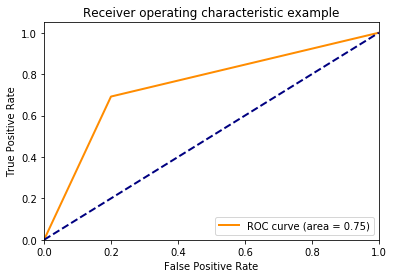

In [190]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ROC curve looks good (not too good) and the area under curve (AUC) is 75%, which is also good, too

Now let's generate some evaluation metrics.

In [164]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.7468508736286062
0.8244908205666871


The accuracy is ~75%, which is the same as we experienced when training and predicting on the same data.

We can also see the confusion matrix and a classification report with other metrics.

In [165]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[1001  250]
 [ 373  837]]
             precision    recall  f1-score   support

        0.0       0.73      0.80      0.76      1251
        1.0       0.77      0.69      0.73      1210

avg / total       0.75      0.75      0.75      2461



## Cross-Validation
<i>When evaluating different settings (“hyperparameters”) for estimators, 
there is still a risk of overfitting on the test set because the parameters 
can be tweaked until the estimator performs optimally. 
This way, knowledge about the test set can “leak” into the model and evaluation 
metrics no longer report on generalization performance. 
To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: 
    training proceeds on the training set, after which evaluation is done on the validation set, 
    and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, 
we drastically reduce the number of samples which can be used for learning the model, 
and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). 
A test set should still be held out for final evaluation, 
but the validation set is no longer needed when doing CV. 
In the basic approach, called k-fold CV, the training set is split into 
k smaller sets (other approaches are described below, but generally follow the same principles). 
The following procedure is followed for each of the k “folds”:

        A model is trained using k-1 of the folds as training data;
        the resulting model is validated on the remaining part of the data 
        (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.</i>

In [176]:
y

array([1., 1., 0., ..., 1., 1., 1.])

In [178]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.03)


With 10-fold cross-validation, it's accuracy is still 75%, which is quite good

## Conclusion & Future Work

In this showcase, I showed a typical Machine Learning algorithm (Logistic Regression) in prediction of the Disk Failure. There are still rooms for improving this preditive model:
* Separate Vendor (Samsung, Hitachi) from Model Name --> one more feature
* including interaction terms
* regularization techniques
* using a non-linear model